# Vehicle Detection

## The Project

The goals / steps of this project are the following:

* Prepare a good training dataset based on GTI, KITTI, CrowdAI image database.
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Normalize features and randomize a selection for training and testing
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Step 1: Create dataset for training

For a machine learning problem, it is very important to work with a good dataset from the very beginning. GTI and KITTI image databases are widely used for research and industry purposes. Additionaly, CrowdAI also provides label vehicle images gathered in the US. After observing the GTI database, I immediately found that the vehicle images are collected based on a continuous video stream therefore, even though there are over 3000 vehicle images in the database, to optimize the classifier, I only plan to use a fraction of them. After subsampling the GTI dataset, new data from CrowAI is added to balance the positive and negative samples. Details on the implementation can be found in this [notebook](https://github.com/mscwu/udacity_vehicle_detection/blob/master/create_pickled_data.ipynb).

### Import Pickled Data

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

try:
    dataset = pickle.load(open('dataset.pickle', 'rb'))
    veh_img = np.array(dataset['vehicle_images'])
    non_veh_img = np.array(dataset['non_vehicle_images'])
    print("Dataset exists. File loaded.")
except (OSError, IOError) as e:
    print("CANNOT FIND DATASET IN CURRENT DIRECTORY!")

try:
    svc_data = pickle.load(open('svc.pickle', 'rb'))
    svc_hsv = svc_data['svc']
    svc_accuracy = svc_data['svc_accuracy']
    color_space = svc_data['color_space']
    orient = svc_data['orient']
    pix_per_cell = svc_data['pix_per_cell']
    cell_per_block = svc_data['cell_per_block']
    hog_channel = svc_data['hog_channel']
    spatial_size = svc_data['spatial_size']
    hist_bins = svc_data['hist_bins']
    spatial_feat = svc_data['spatial_feat']
    hist_feat = svc_data['hist_feat']
    hog_feat = svc_data['hog_feat']
    X_scaler_hsv = svc_data['X_scaler']
    print("SVM model exists. File loaded.")
    retrain = False
    print("SVM info:")
    print('SVC accurary', svc_accuracy)
    print('Color space', color_space)
    print('Orient', orient)
    print('Pixels per cell', pix_per_cell)
    print('Cell per block', cell_per_block)
    print('HOG channel', hog_channel)
    print('Spatial size', spatial_size)
    print('Histogram bins', hist_bins)
except (OSError, IOError) as e:
    print("CANNOT FIND SVM MODEL IN CURRENT DIRECTORY!")
    print("SESSION WILL RETRAIN MODEL!")
    retrain = True

Dataset exists. File loaded.
SVM model exists. File loaded.
SVM info:
SVC accurary 0.9844
Color space HSV
Orient 9
Pixels per cell 8
Cell per block 2
HOG channel ALL
Spatial size (32, 32)
Histogram bins 16


In [2]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import time

### Define Utility Functions

Next, define all the functions learnt along the course.

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Note: my function is different from the function in the lesson as I have already stored all the image matrices in a pickled
# file so they don't need to be read in again.
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Explore the Dataset and Establish Color Spaces to Work with

There a few color space options to work with. To visualize how the images, historgrams, HOG features looks like in each color space, some degree of exploration is necessary. They are done in this [notebook](https://github.com/mscwu/udacity_vehicle_detection/blob/master/Color_Space_Exploration.ipynb).

## Create a Classifier Training Pipeline

A this point, it is useful to write the entire classification pipeline into one function, including feature extraction, feature normalization, train/test split and fitting.

In [4]:
def train_SVC(vehicle, non_vehicle, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', 
              spatial_size=(32,32), hist_bins=32,
              spatial_feat=True, hist_feat=True, hog_feat=True):
    t=time.time()
    car_features = extract_features(vehicle, color_space=color_space, spatial_size=spatial_size,
                                    hist_bins=hist_bins, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(non_vehicle, color_space=color_space, spatial_size=spatial_size,
                                    hist_bins=hist_bins, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')  
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Color space', color_space, '\nOrient', orient,
          '\nPixels per cell', pix_per_cell, '\nCell per block', cell_per_block, '\nHOG channel', hog_channel,
          '\nSpatial size', spatial_size, '\nHistogram bins', hist_bins)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy) 
    
    return svc, accuracy, X_scaler

### Work with RGB Space

In [5]:
if retrain:
    # define tuning parameters
    color_space = 'RGB' # Can be RGB, HSV
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 1 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

In [6]:
if retrain:
    svc_rgb, accuracy_rgb, X_scaler_rgb = train_SVC(veh_img, non_veh_img, color_space=color_space, orient=orient, 
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_size=spatial_size, hist_bins=hist_bins,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

### Work with HSV Space

In [7]:
if retrain:
    # define tuning parameters
    color_space = 'HSV' # Can be RGB, HSV
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 1 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

In [8]:
if retrain:
    svc_hsv, accuracy_hsv, X_scaler_hsv = train_SVC(veh_img, non_veh_img, color_space=color_space, orient=orient, 
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_size=spatial_size, hist_bins=hist_bins,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

It seems that both RGB and HSV give high accuracy results. The difference is almost negligible.

### More HOG Channels

Notice that previously only one channel in each image is used for HOG extraction. Now experiment with all channels and see how that works.

In [9]:
if retrain:
    color_space = 'RGB' # Can be RGB, HSV
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

In [10]:
if retrain:
    svc_rgb, accuracy_rgb, X_scaler_rgb = train_SVC(veh_img, non_veh_img, color_space=color_space, orient=orient, 
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_size=spatial_size, hist_bins=hist_bins,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

In [11]:
if retrain:
    color_space = 'HSV' # Can be RGB, HSV
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

In [12]:
if retrain:
    svc_hsv, accuracy_hsv, X_scaler_hsv = train_SVC(veh_img, non_veh_img, color_space=color_space, orient=orient, 
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_size=spatial_size, hist_bins=hist_bins,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

With more HOG channels, HSV space seems to offer more improvements. Now try increase the spatial bin size of the image.

### Larger Spatial Size and Histogram Bins

In [13]:
if retrain:
    color_space = 'HSV' # Can be RGB, HSV
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

In [14]:
if retrain:
    svc_hsv, accuracy_hsv, X_scaler_hsv = train_SVC(veh_img, non_veh_img, color_space=color_space, orient=orient, 
                                  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                  spatial_size=spatial_size, hist_bins=hist_bins,
                                  spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

It seems that increasing the spatial size and histogram bins provides valuable improvents on the accuracy.

### Save Current Classifier as Pickle File

In [15]:
if retrain:
    svc_pickle = {'svc': svc_hsv, 'svc_accuracy': accuracy_hsv, 'color_space': color_space, 'orient': orient,
             'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'hog_channel': hog_channel, 
             'spatial_size': spatial_size, 'hist_bins': hist_bins, 'spatial_feat': spatial_feat, 'hist_feat': hist_feat,
             'hog_feat': hog_feat, 'X_scaler': X_scaler_hsv}
    print ("Writing pickle file.")
    with open('svc.pickle', 'wb') as f:
        pickle.dump(svc_pickle, f)
        print ("Writing done.")

### Multi-Scale Sliding Window Search with HOG Subsampling

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = pix_per_cell * pix_per_cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [21]:
# get test images
test_image_path = glob.glob('./test_images/test*.jpg')
test_images = []
for img in test_image_path:
    image = cv2.imread(img)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(rgb_image)   

C:\Users\mscwu\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


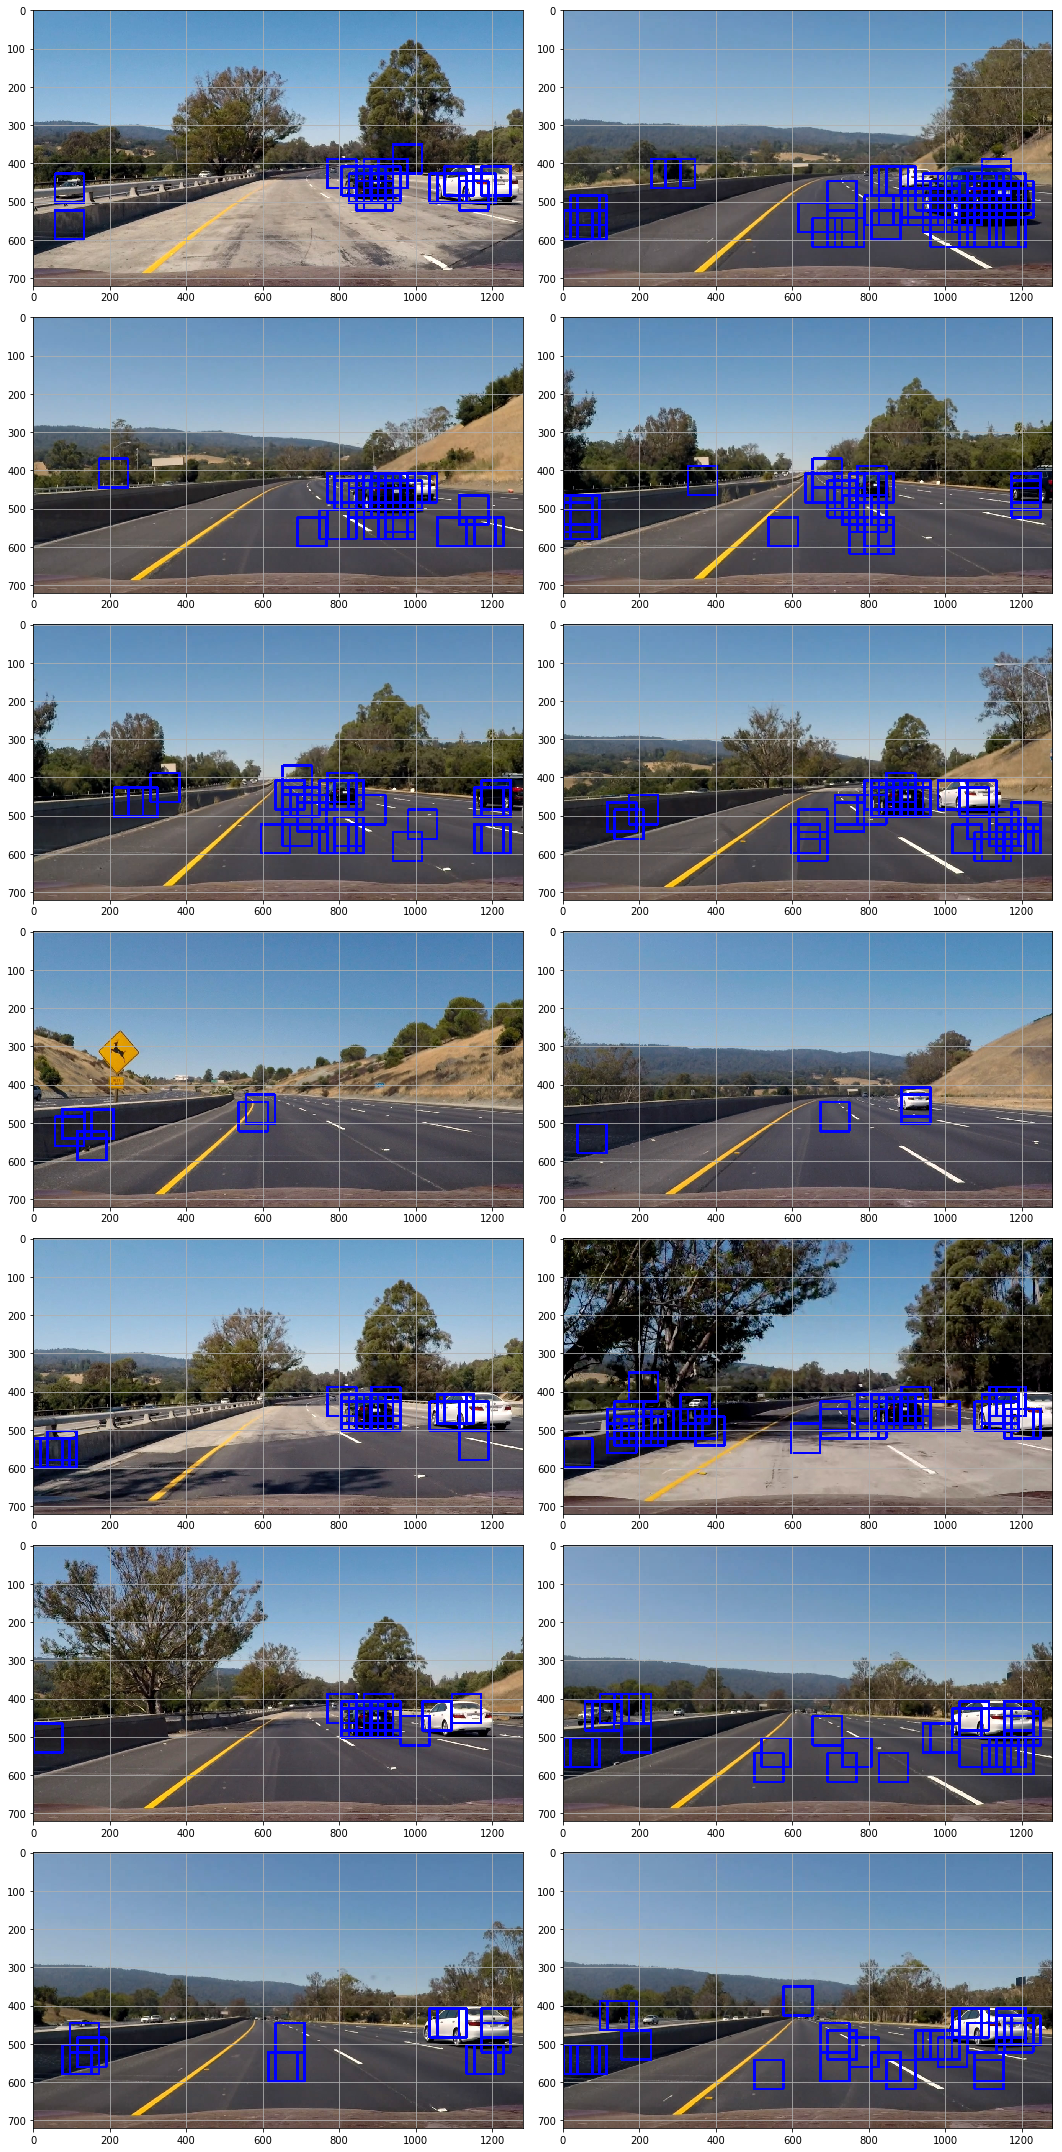

In [22]:
# run test samples
ystart = 350
ystop = 656
scale = 1.2

f, axes = plt.subplots(np.int(len(test_images)/2), 2, figsize=(15,30))
for i, img in enumerate(test_images):
    out_img = find_cars(img, ystart, ystop, scale, svc_hsv, X_scaler_hsv, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    idx = np.unravel_index(i, axes.shape)
    axes[idx].imshow(out_img)
    axes[idx].grid()
plt.tight_layout()

### Use Heatmap to Reduce False Positives

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img